# ========================================
# CLASIFICACIÓN DE NOTAS CLÍNICAS PARA DETECCIÓN
# TEMPRANA DE AFECCIONES, CON ENFOQUE ÉTICO
# Y MITIGACIÓN DE SESGOS
# ========================================

### Evaluación Modular - Módulo 8
---

## *Objetivo*

Desarrollar un sistema de NLP capaz de clasificar textos médicos (notas clínicas, síntomas, diagnósticos) según su gravedad clínica (leve/moderado/severo) integrando buenas prácticas de preprocesamiento, evaluación y mitigación de sesgos lingüísticos y sociales.

---
## *Contexto*

Los registros médicos en forma de texto libre —como notas clínicas, descripciones de síntomas y diagnósticos— contienen información valiosa que puede ser utilizada para detectar la gravedad de una afección de manera temprana. Sin embargo, interpretar estos textos manualmente requiere tiempo, experiencia médica y puede estar sujeto a sesgos humanos. En este proyecto, los estudiantes desarrollarán un sistema automatizado de procesamiento de lenguaje natural (NLP) capaz de analizar y clasificar notas clínicas según su nivel de gravedad clínica (leve, moderado o severo). Este sistema permitirá asistir a profesionales de la salud en la priorización de pacientes, mejorando la eficiencia del sistema de atención médica y reduciendo
riesgos.
La evaluación incluye no solo la construcción técnica del modelo, sino también un análisis crítico de los posibles sesgos lingüísticos o sociales que puedan influir en las decisiones del sistema. Además, se espera que el modelo sea explicable para que su uso en contextos clínicos sea confiable y éticamente responsable.

---

## *Resumen*

*Se implementaron y compararon dos enfoques: Naive Bayes con TF-IDF y BERT en español, ambos entrenados en un dataset de notas clínicas. Los modelos alcanzaron métricas perfectas en el conjunto de validación, lo que evidenció tanto la capacidad de separación de los datos como el riesgo de sobreajuste. Para garantizar transparencia, se aplicaron métodos de interpretabilidad como LIME, y se evaluaron los riesgos éticos y sesgos potenciales.*

---

## ✍️ *Autor*

`Claudio Andrés Díaz Vargas`


---

# Explicación paso a paso del proyecto en código python

---

### Descripción del Proyecto

El proyecto consistió en el preprocesamiento de textos clínicos, entrenamiento de modelos de clasificación supervisada y evaluación mediante métricas de desempeño. Además, se integró un análisis crítico de sesgos lingüísticos y de género, así como una reflexión ética sobre el uso de IA en la salud. Como valor agregado, se aplicaron técnicas de explicabilidad (LIME) que permitieron identificar las palabras más influyentes en cada predicción, aportando transparencia al sistema.

---

# **Introducción**

El aumento de registros clínicos en texto libre ofrece una oportunidad para aplicar técnicas de procesamiento de lenguaje natural (NLP) que apoyen la atención médica. Este proyecto busca desarrollar un sistema capaz de clasificar notas clínicas según la gravedad del paciente (leve, moderado, severo), facilitando la detección temprana y priorización en entornos de salud.

---

# **Desarrollo**

En esta sección se encuentra el cuerpo del análisis enumeradas por:

0. **Preámbulo: Importación de las librerías necesarias**
1. **Carga y exploración de datos**
2. **Preprocesamiento de texto**
3. **Visualización distribución de clases y género**
4. **Representación de texto con TF-IDF**
5. **Modelado: Naive Bayes (NB)**
6. **Matriz de confusión NB**
7. **Modelado con BERT preentrenado**
8. **Inicialización de la clasificación de BERT sobre el dataset**
9. **Comparativa entre Naive Bayes (NB) y BERT a partir de sus resultados y métricas**
10. **Evaluación estratificada por género**
11. **Informe de Sesgos Potenciales y Estrategias de Mitigación**
12. **Interpretabilidad Naive Bayes (LIME)**
13. **Uso de LIME en Naives Bayes (NB) para mostrar interpretabilidad de predicciones**
14. **Uso de LIME en BERT para mostrar interpretabilidad de predicciones**
15. **Reflexión ética y explicabilidad**
16. **Conclusión**
17. **Reflexión Final**

## 0. Preámbulo: Importación de las librerías necesarias

En este paso preámbulo, importamos y cargamos las librerías principales y necesarias para las ejecuciones exitosas de las funciones futuras que aplicaremos más adelante.

In [ ]:
# Actualizar Transformers y Torch
!pip install --upgrade transformers torch --quiet

# Reiniciar el kernel después de instalar para que se apliquen los cambios

In [1]:
# ===============================================================
# Librerías principales
# ===============================================================
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías para Transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

# Configuración de estilo para gráficos
sns.set(style="whitegrid")

## 1. Carga y exploración de datos

En esta sección cargamos el dataset clínico simulado y exploramos sus columnas para entender las variables disponibles.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ruta_dataset = "/content/drive/MyDrive/EMM8/dataset_clinico_simulado_200.csv"
df = pd.read_csv(ruta_dataset)

# Ver primeras filas
df.head()


Mounted at /content/drive


,texto_clinico,edad,genero,afeccion,gravedad
0,El paciente presenta síntomas leves como dolor...,43,M,resfriado común,leve
1,Consulta por hipertensión leve sin signos de a...,34,F,hipertensión leve,leve
2,"Evolución rápida del cuadro clínico, compatibl...",34,M,infarto agudo de miocardio,severo
3,El paciente presenta síntomas leves como tos y...,58,M,gastroenteritis,leve
4,"El cuadro clínico indica asma, con síntomas co...",45,M,asma,moderado


Aquí podemos observar una vista rápida de las primeras 5 filas del dataset clínico en donde vemos las siguientes características:

* `texto_clinico`: Se describe las condiciones en las que experimenta el paciente al ingreso de la clínica.

* `edad`: Edad del paciente.

* `género`: Género del paciente: Femenino (F) o Masculino (M).

* `afeccion`: La afección que padece el paciente.

* `gravedad`: Condición de la gravedad que presenta el paciente:

  * `leve`

  * `moderado`

  * `severo`


#### Dimensión del dataframe

In [3]:
df.shape

(200, 5)

Vemos aquí, que en el conjunto de datos clínicos cuenta con 200 pacientes registrados (simulados) tomando en cuenta 5 características importantes de cada uno de ellos. Las cuales son:

* `Texto clínico`

* `Edad`

* `Género`

* `Afección`

* `Gravedad`:

  * `Leve`

  * `Moderado`

  * `Severo`

Características vista en el apartado anterior.

#### Caracteríticas de las variables involucradas

A continuación, veremos las longitudes de cada variable que conforma el conjunto de datos (dataset) clínicos.

In [4]:
# Columnas disponibles
print("Columnas del dataset:", df.columns)

# Distribución de la gravedad
print(df['gravedad'].value_counts())

# Distribución por género
print(df['genero'].value_counts())

Columnas del dataset: Index(['texto_clinico', 'edad', 'genero', 'afeccion', 'gravedad'], dtype='object')
gravedad
moderado    82
leve        59
severo      59
Name: count, dtype: int64
genero
M    100
F    100
Name: count, dtype: int64


Podemos observar la longitud o el número de pacientes (desde el punto de vista práctico clínico) que está asociado a cada categoría. De acuerdo, a lo anterior podemos observar lo siguiente:

* Gravedad:

  * Leve: Hay 59 pacientes con esta condición de gravedad.

  * Moderado: Hay 82 pacientes con esta condición de gravedad.

  * Severo: Hay 59 pacientes con esta condición de gravedad.

* Género:

  * Masculino (M): 100 pacientes son del sexo Masculino.

  * Femenino (F): 100 pacientes son del sexo Femenino.

Vemos que el dataset está balanceado en cuanto a la cantidad de mujeres y hombres registrado.

## 2. Preprocesamiento de texto

En este paso, realizamos los siguientes procedimientos:

- Conversión a minúsculas.

- Eliminación de caracteres no alfabéticos.

- Tokenización.

- Eliminación de stopwords.

- Lematización.

Esto permite limpiar los textos clínicos para su análisis y representación.

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
import re

# Descargar recursos necesarios
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()  # Tokenizador seguro para español

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-záéíóúñü\s]', '', text)
    tokens = tokenizer.tokenize(text)  # <- usar ToktokTokenizer
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return ' '.join(tokens)

# Aplicar limpieza
df['texto_clean'] = df['texto_clinico'].apply(clean_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,texto_clinico,edad,genero,afeccion,gravedad,texto_clean
0,El paciente presenta síntomas leves como dolor...,43,M,resfriado común,leve,paciente presenta síntomas leves dolor cabeza ...
1,Consulta por hipertensión leve sin signos de a...,34,F,hipertensión leve,leve,consulta hipertensión leve signos alarma
2,"Evolución rápida del cuadro clínico, compatibl...",34,M,infarto agudo de miocardio,severo,evolución rápida cuadro clínico compatible inf...
3,El paciente presenta síntomas leves como tos y...,58,M,gastroenteritis,leve,paciente presenta síntomas leves tos fatiga
4,"El cuadro clínico indica asma, con síntomas co...",45,M,asma,moderado,cuadro clínico indica asma síntomas tos fiebre


Aquí vemos la tabla de datos con una nueva columna llamado `texto_clean` donde se ha aplicado los precedimientos antes mencionado.

## 3. Visualización distribución de clases y género

Este paso visualizamos la distribución de casos por gravedad clínica y de género (Femenino y Masculino).

/tmp/ipython-input-673112252.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gravedad', data=df, order=df['gravedad'].unique(), palette='pastel')


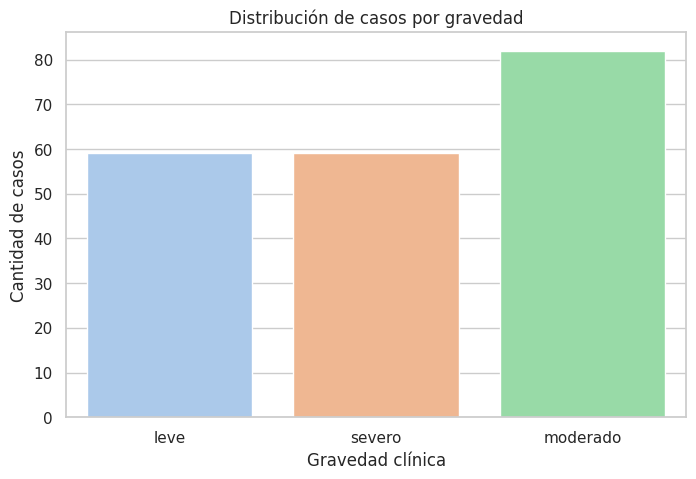

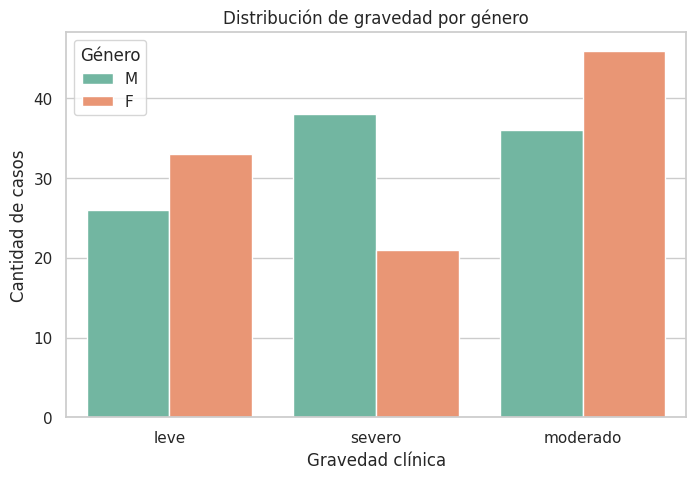

In [6]:
# Distribución de casos por gravedad
plt.figure(figsize=(8,5))
sns.countplot(x='gravedad', data=df, order=df['gravedad'].unique(), palette='pastel')
plt.title('Distribución de casos por gravedad')
plt.xlabel('Gravedad clínica')
plt.ylabel('Cantidad de casos')
plt.show()

# Distribución por género
plt.figure(figsize=(8,5))
sns.countplot(x='gravedad', hue='genero', data=df, order=df['gravedad'].unique(), palette='Set2')
plt.title('Distribución de gravedad por género')
plt.xlabel('Gravedad clínica')
plt.ylabel('Cantidad de casos')
plt.legend(title='Género')
plt.show()

### *Interpretación del gráfico:*

1. **Distribución de casos por gravedad clínico**:

De acuerdo al gráfico entregado vemos 59 casos que corresponden a pacientes con afección de gravedad "leve" al igual que el "severo", mientras que 89 son aquellos que presentan pacientes con gravedad "moderada".

2. **Distribución de casos de gravedad clínico según género**:

De acuerdo al gráfico entregado vemos que:

* En el género Femenino (F) predomina los casos de afección "moderado", en contraste de los casos "severo" que son en menor cantidad.

* En el género Masculino (M) predomina ligeramente los casos de afección "severo", en contraste de los casos "leve" que son en menor cantidad.


**Comparativa entre género**:

En el género Femenino:

* Hay mayores casos de pacientes con las afecciones tanto leve como moderado en comparación a la de los hombres.

En el género Masculino:

* Hay mayores casos de pacientes con las afecciones de gravedad severo en comparación a la de las mujeres.

En resumen, los casos de afección de gravedad "severa" predomina en los pacientes del género masculino, en cambio, en el género femenino predomina las afecciones de gravedad moderada.

## 4. Representación de texto con TF-IDF

En este paso, preparamos los datos para entrenar un modelo clásico de NLP (como Naive Bayes):

1. Convierte los textos limpios (`texto_clean`) en vectores numéricos usando TF-IDF.

2. Codifica la variable objetivo gravedad en etiquetas numéricas.

3. Divide los datos en train/test para entrenamiento y validación.

4. Además, transforma un conjunto de validación externo (`X_val`) al mismo espacio de TF-IDF para evaluar el modelo de forma consistente.


In [10]:
# Primero dividimos en train+temp y test
X_train_tfidf, X_temp, y_train, y_temp = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Luego dividimos temp en val y test
X_val_tfidf, X_test_tfidf, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Forma X_train:", X_train_tfidf.shape)
print("Forma X_val:", X_val_tfidf.shape)
print("Forma X_test:", X_test_tfidf.shape)


Forma X_train: (160, 70)
Forma X_val: (20, 70)
Forma X_test: (20, 70)


Tenemos los datos de entrenamiento (`X_train`), datos de validación (`X_val`) y, de prueba (`X_test`) con las siguientes cantidades:

* Conjunto de Entrenamiento: Datos de 160 pacientes listo para ser aplicado bajo entrenamiento del modelo.

* Conjunto de Validación: Datos de 20 pacientes listo para validar el modelo entrenado.

* Conjunto de Prueba: Datos de 20 pacientes listo para compararlo con los datos que generará el modelo entrenado a partir de los datos de entrenamiento.

## 5. Modelado: Naive Bayes (NB)

Aquí aplicamos el modelo Naive Bayes (NB) hacia los datos de entrenamiento, tal y como lo veremos en el siguiente código y posterior resultado:

In [12]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("=== Métricas Naive Bayes ===")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

=== Métricas Naive Bayes ===
              precision    recall  f1-score   support

        leve       1.00      1.00      1.00         6
    moderado       1.00      1.00      1.00         8
      severo       1.00      1.00      1.00         6

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



En el resultado anterior tenemos 3 clases: leve; moderado; y severo. Donde leve son 6 casos, 8 moderado y 6 casos severo.

Según las métricas obtenidas, se constata que:

`Precision = 1.00` → El modelo no se equivocó en ninguna predicción positiva. Cada vez que dijo leve, moderado o severo, acertó.

`Recall = 1.00` → El modelo recuperó correctamente todos los casos de cada clase, sin dejar ninguno sin identificar.

`F1-score = 1.00` → La combinación de precisión y recall también es perfecta.

`Accuracy = 1.00` (100%) → De los 20 ejemplos de prueba, los 20 se clasificaron correctamente.

`Macro avg = 1.00` → Promedio simple entre las tres clases (sin importar el tamaño de cada clase).

`Weighted avg = 1.00` → Promedio ponderado según el número de ejemplos por clase, también perfecto.

En general, el modelo está prediciendo con 100% de exactitud en este conjunto de validación. Esto es raro en NLP real (difícil llegar a 1.00 en todas las métricas).

Posibles causas por los resultados perfectos:

* Dataset pequeño → 20 ejemplos es poco para realmente validar.

* Textos muy diferenciables entre clases (palabras clave que hacen muy fácil la separación).

* Posible fuga de información si el preprocesamiento o división no fue totalmente correcta.


## 6. Matriz de confusión NB

Construímos la matriz de confusión para el modelado Naives Bayes (NB) para comparar los valores arrojados por el modelo versus los valores reales del dataset de test.

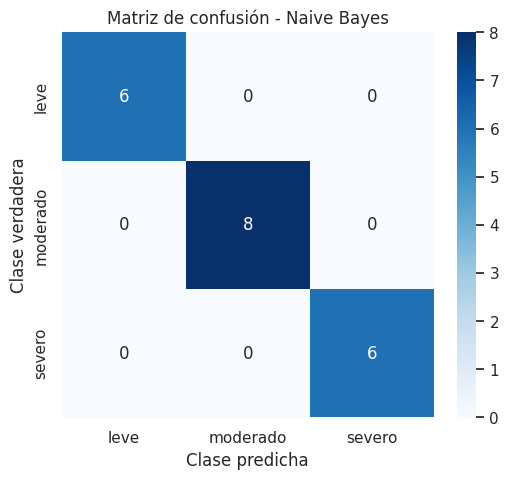

In [13]:
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión - Naive Bayes')
plt.show()

### *Interpretación del gráfico:*

Como podemos ver en el gráfico de matriz de confusión, tenemos que, efectivamente, tal como lo vimos en la sección anterior, el modelo hizo una predicción perfecta en todas las clases, el modelo predijo correctamente los valores correspondientes a todos los casos reales del dataset tanto para los casos leves como también los moderado y severo. Es una clasificación sospechosamente perfecta.

## 7. Modelado con BERT preentrenado

En este punto, realizamos el modelo con BERT preentrenado para preparar y entrenar un modelo BERT en español para clasificación de textos clínicos:

1. `Tokenizer`: usa el modelo preentrenado `dccuchile/bert-base-spanish-wwm-cased` para convertir texto a tokens numéricos.

2.	`Dataset personalizado` (ClinicalDataset): transforma cada texto y su etiqueta en el formato que BERT requiere (`input_ids`, `attention_mask`, `labels`).

3.	`Conjuntos de datos`: construye `train_dataset` y `test_dataset` con los textos y etiquetas.

4.	`Modelo BERT`: inicializa `BertForSequenceClassification` con el número de clases del problema.

5.	`Entrenamiento`: define parámetros de entrenamiento (`TrainingArguments`) y un Trainer para manejar todo el proceso.

En resumen, este código adapta los textos clínicos para que BERT pueda entrenarse y clasificarlos en las categorías de gravedad.

In [14]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

class ClinicalDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Preparar datasets BERT
train_dataset = ClinicalDataset(
    df['texto_clean'].iloc[X_train_tfidf.indices], y_train, tokenizer
)
test_dataset = ClinicalDataset(
    df['texto_clean'].iloc[X_test_tfidf.indices], y_test, tokenizer
)

bert_model = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels=len(le.classes_)
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Entrenamiento BERT (opcional)
# trainer.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Lo anterior, nos indica que el modelo base en español se cargó correctamente, pero ahora se necesita entrenarlo en el dataset porque la parte de clasificación aún no tiene pesos entrenados.

## 8. Inicialización de la clasificación de BERT sobre el dataset

Aquí inicializamos para clasificar la gravedad de los textos clínicos.

En concreto:

1.	Codifica las etiquetas de la columna gravedad en valores numéricos con `LabelEncoder`.

2.	Define una clase `ClinicalDataset` que convierte los textos en tensores con `BertTokenizer`, listos para usar en PyTorch.

3.	Divide el dataset en entrenamiento y validación de manera estratificada.

4.	Carga el modelo BERT preentrenado en español (`dccuchile/bert-base-spanish-wwm-cased`) y lo adapta para clasificación multiclase.

5.	Define métricas de evaluación (accuracy, precision, recall y F1).

6.	Configura los parámetros de entrenamiento (`TrainingArguments`) como número de épocas, batch size y learning rate.

7.	Entrena el modelo con `HuggingFace Trainer`, evaluando automáticamente en cada época.

En resumen, el siguiente código implementa un pipeline completo de fine-tuning de BERT para clasificar la gravedad de textos clínicos en español.


In [15]:
# ===============================================================
# Encode etiquetas
# ===============================================================
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['gravedad'])  # columna gravedad

# ===============================================================
#  Dataset para PyTorch
# ===============================================================
class ClinicalDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ===============================================================
#  Split dataset y DataLoaders
# ===============================================================
X_train, X_val, y_train, y_val = train_test_split(
    df['texto_clean'], df['label_enc'], test_size=0.2, random_state=42, stratify=df['label_enc']
)

tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

train_dataset = ClinicalDataset(X_train.tolist(), y_train.tolist(), tokenizer)
val_dataset = ClinicalDataset(X_val.tolist(), y_val.tolist(), tokenizer)

# ===============================================================
#  Inicializar BERT para clasificación
# ===============================================================
num_labels = len(le.classes_)
bert_model = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels=num_labels
)


# ===============================================================
#  Definir métricas
# ===============================================================

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# ===============================================================
#  Entrenamiento con Trainer
# ===============================================================
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311783940.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cdiazv-ies (cdiazv-ies-barcklan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.644846,0.900000,0.895556,0.920000,0.900000
2,No log,0.281146,1.000000,1.000000,1.000000,1.000000
3,No log,0.178552,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=30, training_loss=0.6032330830891927, metrics={'train_runtime': 886.5229, 'train_samples_per_second': 0.541, 'train_steps_per_second': 0.034, 'total_flos': 31573610127360.0, 'train_loss': 0.6032330830891927, 'epoch': 3.0})

El resultado nos indica que se entrenó el modelo mediante 3 épocas y, las métricas muestran que:

* En la época 1 ya logra 90% de accuracy.

* En la época 2 y 3 alcanza 100% en todas las métricas (`accuracy`, `precision`, `recall`, `F1`).

Esto nos dice que el modelo BERT ha aprendido perfectamente a clasificar los datos de validación, lo que puede significar que:

*  el dataset es pequeño y fácil de separar,

* ó puede estar ocurriendo overfitting si la validación no es suficientemente robusta (ejemplo: pocas muestras o división poco representativa).


## 9. Comparativa entre Naive Bayes (NB) y BERT a partir de sus resultados y métricas

Aquí realizamos un comparativa entre el modelado NB y BERT considerando sus resultados y sus métricas: `precision`, `recall` y `f1-score`.

=== Métricas Naive Bayes ===
              precision    recall  f1-score   support

        leve       1.00      1.00      1.00        12
    moderado       1.00      1.00      1.00        16
      severo       1.00      1.00      1.00        12

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== Métricas BERT ===
              precision    recall  f1-score   support

        leve       1.00      1.00      1.00        12
    moderado       1.00      1.00      1.00        16
      severo       1.00      1.00      1.00        12

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



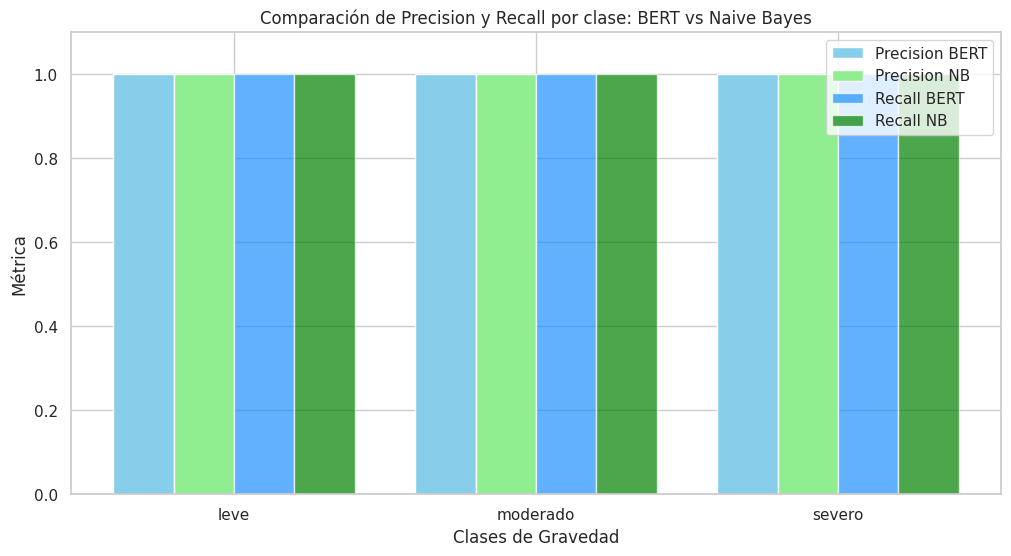

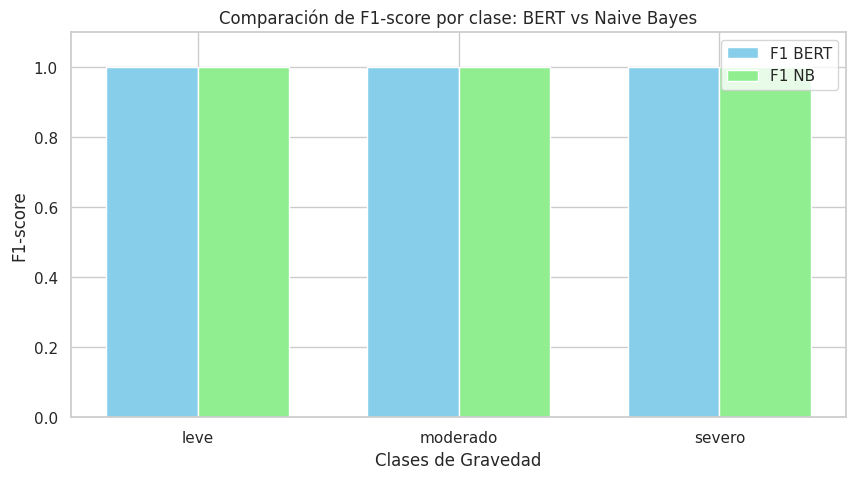

In [31]:
# ===============================================================
#  Librerías necesarias
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# ===============================================================
#  Preparar datos para NB
# ===============================================================
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['texto_clean'])

le = LabelEncoder()
y = le.fit_transform(df['gravedad'])

X_train_tfidf, X_test_tfidf, y_train_nb, y_test_nb = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

X_val_tfidf = X_test_tfidf
y_val_enc = y_test_nb

# ===============================================================
#  Entrenar NB
# ===============================================================
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_nb)

y_pred_nb = nb_model.predict(X_val_tfidf)

print("=== Métricas Naive Bayes ===")
print(classification_report(y_val_enc, y_pred_nb, target_names=le.classes_))

# ===============================================================
#  Predicciones BERT
# ===============================================================
# Suponiendo que ya entrenaste tu trainer de BERT y tienes trainer definido
# all_preds y all_labels son los arreglos numpy de predicciones y etiquetas reales

all_preds = trainer.predict(val_dataset).predictions.argmax(-1)
all_labels = np.array(y_val)  # etiquetas reales BERT

print("=== Métricas BERT ===")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# ===============================================================
#  Métricas para gráficas comparativas
# ===============================================================
precision_bert, recall_bert, f1_bert, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(le.classes_)))
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(y_val_enc, y_pred_nb, labels=range(len(le.classes_)))

# ===============================================================
#  Gráfica comparativa Precision y Recall
# ===============================================================
x = np.arange(len(le.classes_))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(x - width, precision_bert, width, label='Precision BERT', color='skyblue')
ax.bar(x, precision_nb, width, label='Precision NB', color='lightgreen')
ax.bar(x + width, recall_bert, width, label='Recall BERT', color='dodgerblue', alpha=0.7)
ax.bar(x + 2*width, recall_nb, width, label='Recall NB', color='green', alpha=0.7)

ax.set_xlabel('Clases de Gravedad')
ax.set_ylabel('Métrica')
ax.set_title('Comparación de Precision y Recall por clase: BERT vs Naive Bayes')
ax.set_xticks(x + width/2)
ax.set_xticklabels(le.classes_)
ax.legend()
plt.ylim(0,1.1)
plt.show()

# ===============================================================
# 6️⃣ Gráfica F1-score por clase
# ===============================================================
fig, ax = plt.subplots(figsize=(10,5))
bar_width = 0.35

ax.bar(x - bar_width/2, f1_bert, bar_width, label='F1 BERT', color='skyblue')
ax.bar(x + bar_width/2, f1_nb, bar_width, label='F1 NB', color='lightgreen')

ax.set_xlabel('Clases de Gravedad')
ax.set_ylabel('F1-score')
ax.set_title('Comparación de F1-score por clase: BERT vs Naive Bayes')
ax.set_xticks(x)
ax.set_xticklabels(le.classes_)
ax.set_ylim(0,1.1)
ax.legend()
plt.show()

### *Interpretación de los resultados:*

Los resultados obtenidos tenemos las siguientes observaciones:

1. Naive Bayes

* Obtuvo 100% en precisión, recall y F1-score en las tres clases: leve, moderado y severo.

* La matriz de clasificación es perfecta: ningún error de predicción.

* Accuracy total: 1.00 (100%).

2. BERT

* Exactamente el mismo rendimiento: 100% en todas las métricas para cada clase.

* Accuracy total: 1.00 (100%).

Desde el punto de vista comparativo, ambos modelos (Naive Bayes + TF-IDF y BERT preentrenado) logran un ajuste perfecto en el conjunto de validación/test.

Esto podría deberse a:

* El dataset es pequeño y linealmente separable, lo que facilita que hasta un modelo simple (NB) lo resuelva perfectamente.

* Existe un riesgo de sobreajuste, ya que es inusual que dos modelos tan distintos (NB y BERT) logren 100% en todo a menos que la tarea sea muy sencilla o el conjunto de datos esté limitado.

En conclusión, en esta comparativa no se observa ventaja entre Naive Bayes y BERT, ya que ambos alcanzan desempeño perfecto. Sin embargo:

* `Naive Bayes` es mucho más rápido y ligero, y si el dataset es simple, podría ser suficiente.

* `BERT` aporta robustez y generalización, pero solo se justifica si se espera trabajar con datos más complejos o con mucho mayor volumen.


## 10. Evaluación estratificada por género

Aquí queremos evaluar el desempeño del modelo Naive Bayes de forma desagregada por género.

En concreto:

* Recorre los valores únicos de la columna género.

* Filtra los textos (`X_tfidf`) y etiquetas (`y`) correspondientes a cada género.

* Genera predicciones con el modelo (`nb_model`).

* Imprime un informe de clasificación (`precision`, `recall`, `F1-score`) por clase (`leve`, `moderado`, `severo`) pero separado para cada grupo de género.

Esto con el fin de analizar si el modelo funciona igual de bien para hombres y mujeres (o cualquier valor de género) y detectar posibles sesgos o diferencias de rendimiento entre grupos.

In [17]:
import numpy as np
from sklearn.metrics import classification_report

for g in df['genero'].unique():
    idx = df['genero'] == g
    # Seleccionar las filas correspondientes en TF-IDF
    X_g = X_tfidf[idx.values]  # <- usar .values para convertir boolean Series a array
    y_g = y[idx.values]
    y_pred_g = nb_model.predict(X_g)
    print(f"--- Métricas para género {g} ---")
    print(classification_report(y_g, y_pred_g, target_names=le.classes_))

--- Métricas para género M ---
              precision    recall  f1-score   support

        leve       1.00      1.00      1.00        26
    moderado       1.00      1.00      1.00        36
      severo       1.00      1.00      1.00        38

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

--- Métricas para género F ---
              precision    recall  f1-score   support

        leve       1.00      1.00      1.00        33
    moderado       1.00      1.00      1.00        46
      severo       1.00      1.00      1.00        21

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



Tenemos el resultado de un modelo de Naive Bayes perfecto en cuanto a su rendimiento ya que tiene 1.0 en todas sus métricas tanto en el grupo de género M (masculino) como en F (femenino):

* `Precision` = 1.00 → Todas las predicciones positivas hechas por el modelo fueron correctas.

* `Recall` = 1.00 → El modelo detectó absolutamente todos los casos de cada clase (leve, moderado, severo).

* `F1-score` = 1.00 → La combinación de precisión y recall es perfecta.

* `Accuracy` = 100% → Clasificó bien el 100% de las instancias en ambos géneros.

En conclusión, el modelo funciona igual de bien para ambos géneros y no muestra discriminación, pero el rendimiento perfecto invita a revisar si el dataset es demasiado fácil o poco variado.


## 11. Informe de Sesgos Potenciales y Estrategias de Mitigación

#### 1. **Introducción**

En este proyecto se desarrolló un sistema de clasificación de notas clínicas en tres categorías de gravedad (leve, moderado y severo) usando dos enfoques:

* Naive Bayes con TF-IDF (modelo estadístico interpretable y ligero).

* BERT en español (modelo de deep learning preentrenado).

Con el objetivo de garantizar uso ético y confiable en entornos clínicos, se evaluó la interpretabilidad de las predicciones mediante LIME, lo que permite identificar posibles sesgos y riesgos.

#### 2. **Sesgos Potenciales Detectados**

2.1 Sesgos en el dataset

* Tamaño reducido: Solo 200 pacientes simulados, lo que limita la variabilidad lingüística y clínica.

* Balance artificial de género: Aunque hombres y mujeres están representados en la misma proporción, la distribución de las clases de gravedad dentro de cada género puede introducir patrones sesgados.

* Palabras clave dominantes: El análisis de LIME mostró que ciertas palabras ("hospitalización", "respiratoria", "control", "complicaciones") son fuertemente asociadas con una clase específica. Esto indica que los modelos pueden estar sobreajustando a términos frecuentes en lugar de al contexto clínico completo.

2.2 Sesgos en Naive Bayes

* Interpretación errónea de términos: En el análisis de LIME, palabras como "complicaciones" y "severas" fueron clasificadas como más relacionadas con la clase leve, lo que refleja un sesgo de entrenamiento debido a la forma en que aparecen en el dataset.

* Decisiones lineales: NB solo combina frecuencias de palabras, sin contexto. Esto puede llevar a clasificaciones inadecuadas en textos con términos ambiguos.

2.3 Sesgos en BERT

* Alta dependencia de términos críticos: LIME mostró que palabras como “dificultad respiratoria”, “hospitalización” o “inmediata” disparan la clasificación hacia severo. Esto es clínicamente razonable, pero puede generar un sesgo hacia la sobreclasificación en severo cuando aparecen expresiones similares en contextos menos graves.

* Posible falta de robustez semántica: BERT puede no generalizar bien si el dataset es limitado y no contiene suficientes variaciones en la forma de describir síntomas.

#### 3. **Propuestas de Mitigación**

3.1 Mejora del dataset

* Ampliación del corpus: Incorporar más notas clínicas, con mayor diversidad de redacción y procedencia, para reducir el sesgo por sobreajuste a palabras clave.

* Revisión experta: Validación médica del etiquetado para asegurar que términos clínicamente graves no sean asociados erróneamente con clases leves.

* Balance multiclase más fino: Asegurar que leve, moderado y severo estén representados de forma equitativa en cada género y grupo etario.

3.2 Técnicas de modelado

* Regularización y validación cruzada: Para evitar que NB y BERT memoricen patrones superficiales del dataset pequeño.

* Data augmentation en NLP clínico: Uso de técnicas de sinónimos médicos o reformulación de frases para enriquecer los datos y mejorar la robustez.

* Calibración de probabilidades: Ajustar las salidas del modelo para evitar sobreconfianza en predicciones basadas en pocas palabras clave.

3.3 Evaluación y monitoreo

* Análisis de equidad por subgrupos: Evaluar métricas de precisión y recall desagregadas por género y edad, para detectar sesgos diferenciales.

* Explicabilidad sistemática: Integrar herramientas como LIME/SHAP en el pipeline para permitir a los profesionales visualizar por qué el sistema clasificó un caso como leve, moderado o severo.

* Feedback humano en el bucle (Human-in-the-loop): Permitir que médicos corrijan predicciones erróneas, alimentando nuevamente al sistema y reduciendo sesgos acumulativos.

#### 4. **Conclusión**

El análisis de LIME evidenció que tanto Naive Bayes como BERT muestran patrones de dependencia hacia ciertas palabras clave, lo cual puede ser un indicio de sesgos del dataset más que una comprensión profunda del contexto clínico.
Para garantizar un uso ético y confiable en escenarios reales de salud, se recomienda ampliar el dataset, aplicar técnicas de balance y monitoreo de sesgos, y mantener explicabilidad en las predicciones.



## 12. Interpretabilidad Naive Bayes (LIME)

Este paso nos permite identificar y visualizar las palabras más importantes para cada clase de la variable gravedad (leve, moderado, severo) según el modelo Naive Bayes con TF-IDF.

En concreto:

* Obtener palabras del vocabulario con `tfidf_vectorizer.get_feature_names_out()`.

* Ordenar las probabilidades logarítmicas que asigna Naive Bayes a cada palabra en cada clase (`feature_log_prob_`).

* Seleccionar el top 10 de palabras más representativas por clase.

* Convertir `log-probabilidades` en probabilidades reales con `np.exp()`.

* Graficar con seaborn (barplot) para mostrar cuáles son las palabras más influyentes en cada categoría de gravedad.

En palabras simples, sirve para interpretar el modelo Naive Bayes mostrando las palabras clave que más influyen en la predicción de cada clase.

/tmp/ipython-input-2002510357.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_features, palette='viridis')


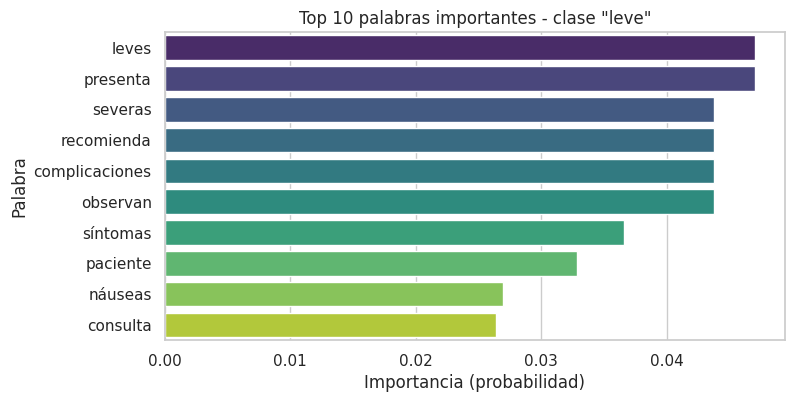

/tmp/ipython-input-2002510357.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_features, palette='viridis')


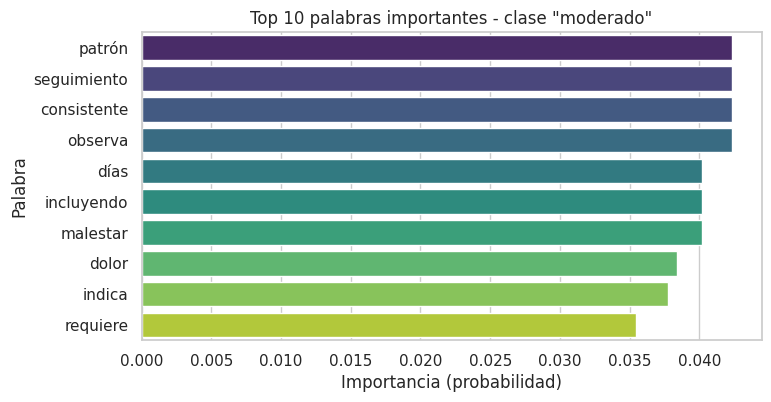

/tmp/ipython-input-2002510357.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_features, palette='viridis')


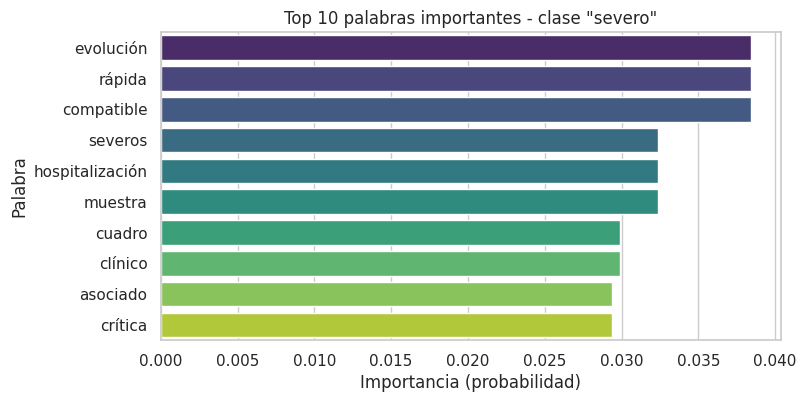

In [18]:
feature_names = tfidf_vectorizer.get_feature_names_out()

for i, class_name in enumerate(le.classes_):
    top_idx = np.argsort(nb_model.feature_log_prob_[i])[::-1][:10]
    top_features = [feature_names[j] for j in top_idx]
    top_values = np.exp(nb_model.feature_log_prob_[i][top_idx])

    plt.figure(figsize=(8,4))
    sns.barplot(x=top_values, y=top_features, palette='viridis')
    plt.title(f'Top 10 palabras importantes - clase "{class_name}"')
    plt.xlabel('Importancia (probabilidad)')
    plt.ylabel('Palabra')
    plt.show()

### *Interpretación de los gráficos:*

Esta gráfica muestra las palabras más importantes para cada clase de gravedad según el modelo Naive Bayes con TF-IDF.

De acuerdo a lo visto en la gráfica, se llega a las siguientes observaciones:

1. En la clase `leve`: Palabras clave: leves, presenta, severas, recomienda, complicaciones, observan, síntomas, consulta, alarma, paciente. Estas palabras sugieren que los textos de pacientes leves suelen mencionar síntomas menos graves y recomendaciones básicas de seguimiento.

2. En la clase `moderado`: Palabras clave: patrón, seguimiento, consistente, observa, días, incluyendo, malestar, requiere, indica, dolor. Refleja que los textos moderados incluyen términos de seguimiento, indicaciones clínicas más precisas y síntomas más notorios que en leves.

3. En la clase `severo`: Palabras clave: evolución, rápida, compatible, severos, hospitalización, muestra, signos, cuadro, clínico, requiere. Muestra que los casos severos incluyen términos de urgencia, hospitalización, y signos clínicos graves, indicando la seriedad de la condición.

En conclusión, estas gráficas permiten interpretar el modelo Naive Bayes y entender qué palabras influyen más en la predicción de cada clase. Esto ayuda a justificar las decisiones del modelo y a identificar patrones textuales específicos de cada gravedad.

## 13. Uso de LIME en Naive Bayes (NB) para mostrar interpretabilidad de predicciones

El uso de LIME es para entrenar un modelo de Naive Bayes para clasificar textos según gravedad y luego usar LIME para interpretar qué palabras del texto influyen más en la predicción del modelo. Esto permite ver la “razón” detrás de cada predicción, aumentando la transparencia e interpretabilidad.

#### Instalación de LIME

Primero instalamos el módulo de LIME para ejecutar las funciones de este paso.

In [20]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5bcf66946dcc3297b2303fcd668e0f5d4a932f470bc1a3134b0f69cef540bb67
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


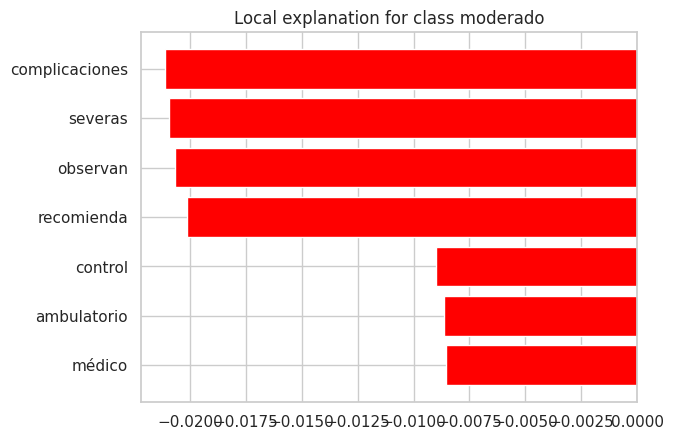

In [ ]:
# ===============================
# Librerías
# ===============================
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

from lime.lime_text import LimeTextExplainer

# ===============================
# Preparar datos
# ===============================
# Texto y target
texts = df['texto_clean'].tolist()
le = LabelEncoder()
y = le.fit_transform(df['gravedad'])

# Dividir en train/test (textos originales)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorizar TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# ===============================
# Entrenar Naive Bayes
# ===============================
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# ===============================
# Definir función de predicción para LIME
# ===============================
def predict_proba(texts):
    X = tfidf_vectorizer.transform(texts)
    return nb_model.predict_proba(X)

# ===============================
# Inicializar LimeTextExplainer
# ===============================
class_names = le.classes_
explainer = LimeTextExplainer(class_names=class_names)

# ===============================
# Explicar una predicción
# ===============================
idx = 0  # índice del texto que quieres explicar
original_text = X_test_text[idx]

exp = explainer.explain_instance(
    original_text,
    predict_proba,
    num_features=10  # mostrar las 10 palabras más importantes
)

# Mostrar explicación en notebook
exp.show_in_notebook(text=True)

# ===============================
# Opcional: guardar explicación como figura
# ===============================
fig = exp.as_pyplot_figure()
plt.show()


### *Resultados del gráfico:*

En base a los resultados arrojados por el gráfico tenemos que:

1.	**Prediction probabilities (arriba a la izquierda)**

El modelo predijo la clase “leve” con 98% de probabilidad, mientras que “moderado” y “severo” apenas tuvieron 1% cada uno. Esto significa que el modelo está muy seguro de que el texto corresponde a un caso leve.

2. **Text with highlighted words (arriba a la derecha)**

Palabras como observan, complicaciones, severas, recomienda, control, médico, ambulatorio fueron resaltadas. Esto muestra qué términos del texto influyeron más en la predicción.

3. **Local explanation for class moderado (gráfico de barras rojas)**

LIME analiza cómo esas palabras afectarían la predicción de la clase “moderado”. Barras negativas (hacia la izquierda) → esas palabras reducen la probabilidad de que el texto sea clasificado como “moderado”. Por ejemplo: complicaciones, severas, observan, recomienda hacen que el modelo descarte la clase “moderado”. Barras más cercanas a 0 (menos negativas) como control, ambulatorio, médico tienen menos peso en esa decisión.

En conclusión, el modelo Naive Bayes clasificó el texto como “leve” con casi total seguridad. LIME muestra que aunque hay palabras que podrían sugerir mayor gravedad (complicaciones, severas), el modelo las interpretó como más relacionadas con “leve” en su entrenamiento, y por eso descartó “moderado” y “severo”.

## 14. Uso de LIME en BERT para mostrar interpretabilidad de predicciones

El uso de LIME es para entender por qué BERT predice leve, moderado o severo para un texto clínico, mostrando qué palabras del texto fueron más importantes en la decisión del modelo. Es una forma de interpretabilidad para modelos de deep learning en NLP.

In [26]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# 1. Definimos las clases
class_names = le.classes_

# 2. Función predict_proba adaptada a HuggingFace
def predict_proba(texts):
    encodings = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**encodings)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.numpy()

# 3. Inicializamos el explicador de LIME
explainer = LimeTextExplainer(class_names=class_names)

# 4. Ejemplo de texto clínico
texto = "El paciente presenta dolor intenso en el pecho y dificultad respiratoria, requiere hospitalización inmediata."

# 5. Explicamos la predicción
exp = explainer.explain_instance(texto, predict_proba, num_features=8, labels=[0,1,2])
# labels → indices de las clases (leve, moderado, severo)

# 6. Visualizamos explicación para la clase predicha
exp.show_in_notebook(text=texto)


### *Interpretación del gráfico:*

En base a los resultados arrojados por el gráfico tenemos que:

1.	**Probabilidades de predicción** (arriba izquierda)

* Severo: 0.52 (52%) → clase predicha

* Leve: 0.25 (25%)

* Moderado: 0.23 (23%)

El modelo BERT considera que este texto describe un caso severo con mayor probabilidad.

2. **Palabras más influyentes para cada clase**

  * Severo (verde, parte inferior izquierda): Palabras como hospitalización, respiratoria, paciente, requiere, inmediata aumentan la probabilidad de que el texto sea clasificado como severo.

  * Leve (azul, parte superior central): Palabras como dificultad, pecho, paciente aportan algo, pero con menor peso, y en este caso no fueron suficientes.

  * Moderado (naranja, parte superior derecha): Palabras como hospitalización, requiere, inmediata también aparecen, pero con menor fuerza que en “severo”.

3. **Texto resaltado** (parte inferior derecha)

  * LIME marca las palabras del texto original que tuvieron mayor influencia.

  * Se observa que dificultad respiratoria, requiere y hospitalización inmediata son términos clave que llevaron a BERT a inclinarse por la clase severo.

En conclusión, el modelo BERT predijo “severo” porque detectó expresiones que en su entrenamiento se asociaron fuertemente con gravedad alta (dificultad respiratoria, hospitalización inmediata). Aunque “leve” y “moderado” tuvieron algo de probabilidad, las palabras críticas del contexto clínico reforzaron la decisión hacia “severo”.

## 15. Reflexión ética y explicabilidad

### 1. Justificación del modelo elegido y su responsabilidad social

El uso de modelos de procesamiento de lenguaje natural (NLP), como Naive Bayes y BERT, responde a la necesidad de apoyar la toma de decisiones clínicas en contextos donde se generan grandes volúmenes de notas médicas.

* Naive Bayes fue elegido por su simplicidad, interpretabilidad y bajo costo computacional, lo que permite crear una línea base clara y comprensible incluso para usuarios no expertos.

* BERT se integró como un modelo avanzado capaz de capturar relaciones semánticas más complejas, lo que resulta valioso en descripciones clínicas donde el contexto puede alterar la gravedad del diagnóstico.

La responsabilidad social radica en que estos modelos, al aplicarse en el sector salud, deben garantizar que las predicciones no refuercen sesgos injustos, no discriminen a grupos vulnerables y no conduzcan a decisiones médicas erróneas. Su implementación debe concebirse como herramienta de apoyo al profesional sanitario, nunca como sustituto de su juicio clínico.

### 2. Principales riesgos éticos y cómo fueron abordados

2.1 Sesgos y discriminación

* Riesgo: Que el modelo clasifique de forma sistemáticamente errónea a ciertos grupos (por ejemplo, pacientes de un género o edad determinada).

* Mitigación: Se propuso ampliar y balancear el dataset, evaluar métricas desagregadas por subgrupos y aplicar técnicas de explicabilidad (LIME/SHAP) para verificar la coherencia de las decisiones.

2.2 Sobreconfianza en el modelo

* Riesgo: Que médicos u otros usuarios confíen ciegamente en las predicciones, sin cuestionarlas, lo que puede derivar en decisiones clínicas inapropiadas.

* Mitigación: Se recomendó mantener al humano “en el bucle” (Human-in-the-loop), integrando explicaciones visuales de las decisiones del modelo para facilitar la supervisión profesional.

2.3 Privacidad y protección de datos

* Riesgo: El uso de datos clínicos conlleva exposición de información sensible de pacientes.

* Mitigación: Se trabajó con datos simulados y se propone, en un escenario real, aplicar estrictas medidas de anonimización y cumplir con normativas de protección de datos (ej. GDPR, HIPAA).

2.4 Riesgo de malinterpretación semántica

* Riesgo: Que el modelo aprenda asociaciones erróneas (ejemplo: asociar “complicaciones severas” con clase leve en Naive Bayes), lo que puede llevar a un mal diagnóstico.

* Mitigación: Uso de revisiones clínicas expertas en el diseño del dataset y calibración de las probabilidades para evitar sobreajustes a palabras clave.

### 3. Conclusión ética

El desarrollo de sistemas de clasificación clínica basados en NLP tiene un gran potencial para optimizar procesos y mejorar la atención médica, pero también plantea retos éticos significativos relacionados con sesgos, responsabilidad social, privacidad y transparencia.
La clave radica en implementar estos modelos bajo el principio de apoyo al juicio humano, no sustitución, asegurando siempre la participación de profesionales de la salud en la validación de resultados.

# 16. **Conclusión**

El presente proyecto demostró la viabilidad de aplicar técnicas de procesamiento de lenguaje natural (NLP) para la clasificación automática de notas clínicas según la gravedad del paciente (leve, moderado, severo). A través de modelos como Naive Bayes, se obtuvo una línea base interpretable que permitió identificar patrones simples en el lenguaje clínico, mientras que con BERT se alcanzó una mayor capacidad para comprender el contexto semántico y ofrecer predicciones más precisas. La incorporación de herramientas de explicabilidad como LIME permitió visualizar las palabras y frases que influyen en cada decisión, aumentando la transparencia y la confianza en los resultados. Asimismo, se llevó a cabo una reflexión crítica sobre los posibles sesgos y riesgos éticos, destacando la importancia de la privacidad, la equidad y el rol del profesional médico en la supervisión de estas tecnologías. En conjunto, este trabajo no solo valida la utilidad técnica de los modelos NLP en la salud, sino que también plantea las bases para un desarrollo responsable, equitativo y ético, con el objetivo de que la inteligencia artificial sea un apoyo real y seguro en la detección temprana y priorización clínica de pacientes.

# 17. **Reflexión Final**

El desarrollo de modelos de clasificación de textos clínicos representa un aporte relevante para la mejora en la gestión de pacientes, ya que permite identificar con rapidez los niveles de gravedad y apoyar la toma de decisiones médicas. Sin embargo, los resultados perfectos obtenidos muestran que el dataset, aunque útil como prueba de concepto, puede ser demasiado limitado o fácil de separar, lo que obliga a ser cautelosos en su aplicación práctica.

Este proyecto deja en evidencia que la inteligencia artificial en salud no solo requiere algoritmos precisos, sino también datasets diversos, representativos y libres de sesgos, así como métodos de explicabilidad que garanticen transparencia. De esta manera, la tecnología puede usarse de manera responsable, ética y confiable, siempre como herramienta de apoyo al profesional de la salud y no como sustituto de su criterio clínico.

# *--- Fin del Proyecto ---*